In [1]:
import joblib
from sklearn.preprocessing import StandardScaler , MinMaxScaler, RobustScaler
from sklearn.model_selection import LeaveOneOut
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
# from envs.filtr_json_from_race import load_from_db
import sqlite3
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import KFold

In [4]:
# class LSTMStatePredictor(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size,n_steps_ahead, num_layers=1):
#         super(LSTMStatePredictor, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         # self.fc = nn.Linear(hidden_size, output_size * n_steps_ahead)

#         self.heads = nn.ModuleList([
#         nn.Linear(hidden_size, 2),  # progress
#         nn.Linear(hidden_size, 1),  # fuel
#         nn.Linear(hidden_size, 4),  # wear
#         nn.Linear(hidden_size, 4),  # temp
#         nn.Linear(hidden_size, 1)   # track wetness
#         ])

#         self.scaler_X = None
#         self.scaler_Y = None
#         self.n_steps_ahead = n_steps_ahead
#         self.output_size = output_size

#     # def forward(self, x):
#     #     h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
#     #     c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)

#     #     out, _ = self.lstm(x, (h_0, c_0))

#     #     # Bierzemy ukryty stan z ostatniego kroku czasowego
#     #     last_hidden = out[:, -1, :]  # shape [batch, hidden_size]

#     #     # Każdy head przewiduje własną grupę cech
#     #     outputs = [head(last_hidden) for head in self.heads]  

#     #     # Łączymy wszystko w jeden wektor
#     #     combined = torch.cat(outputs, dim=1)  # [B, 12]

      
#     #     combined = combined.unsqueeze(1).repeat(1, self.n_steps_ahead, 1)
        

#     #     return combined
#     # def forward(self, x, h_c=None):
#     #     # h_c - opcjonalny stan ukryty (batch_first=True)
#     #     out, h_c = self.lstm(x, h_c)
#     #     last_hidden = out[:, -1, :]
#     #     outputs = [head(last_hidden) for head in self.heads]
#     #     combined = torch.cat(outputs, dim=1)
#     #     return combined, h_c
    
#     def forward(self, x, h_c=None):
#         if h_c is None:
#             h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#             c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#             h_c = (h_0, c_0)
        
#         out, h_c = self.lstm(x, h_c)  # h_c = (h_n, c_n)
#         last_hidden = out[:, -1, :]
#         outputs = [head(last_hidden) for head in self.heads]
#         combined = torch.cat(outputs, dim=1).unsqueeze(1)  # shape [B,1,12]
#         return combined, h_c

class LSTMStatePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1,dropout_prob=0.3):
        super(LSTMStatePredictor, self).__init__()
        
        # Zapisz parametry (potrzebne do ewentualnego ręcznego
        # tworzenia stanu, choć nie jest to już wymagane w forward)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        lstm_dropout_prob = dropout_prob if num_layers > 1 else 0.0
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,dropout=lstm_dropout_prob)

        self.dropout_layer = nn.Dropout(dropout_prob)
    
        # Twój świetny pomysł z wieloma głowicami - zostaje!
        self.heads = nn.ModuleList([
            nn.Linear(hidden_size, 2),  # progress
            nn.Linear(hidden_size, 1),  # fuel
            nn.Linear(hidden_size, 4),  # wear
            nn.Linear(hidden_size, 4),  # temp
            nn.Linear(hidden_size, 1)   # track wetness
        ])

        # Te pola nie są już potrzebne Wewnątrz modelu
        # self.scaler_X = None
        # self.scaler_Y = None
        # self.n_steps_ahead = n_steps_ahead # Usuwamy n_steps_ahead
        self.output_size = output_size

    def forward(self, x, h_c=None):
        # 1. Nie musisz ręcznie inicjować h_c. 
        #    nn.LSTM zrobi to automatycznie, jeśli h_c jest None.
        
        # 2. Przetwórz CAŁĄ sekwencję
        #    x ma kształt: [B, seq_len, 37]
        #    out będzie miał kształt: [B, seq_len, hidden_size]
        out, h_c = self.lstm(x, h_c) 

        out = self.dropout_layer(out)  # Zastosuj dropout do wyjścia LSTM
        
        # 3. Zastosuj głowice do CAŁEGO tensora 'out', a nie tylko 'out[:, -1, :]'
        #    head(out) da np. [B, seq_len, 2]
        outputs = [head(out) for head in self.heads]
        
        # 4. Połącz wzdłuż ostatniego wymiaru (wymiaru cech)
        #    List of [B,S,2], [B,S,1], [B,S,4]... -> [B, S, 12]
        #    Używamy dim=2, ponieważ kształt to (Batch, Seq_len, Features)
        combined = torch.cat(outputs, dim=2) 
        
        return combined, h_c
    

def create_scalers(X,Y):

    cont_indices_x = slice(0, 19)   # continuous columns for X (0–18)
    cont_indices_y = slice(0, 12)   # continuous columns for Y (0–11)

    # Scale continuous features
    flat_x = np.vstack([x[:, cont_indices_x] for x in X])
    flat_y = np.vstack([y[:, cont_indices_y] for y in Y])

    # scaler_X = MinMaxScaler().fit(flat_x)
    # # scaler_Y = MinMaxScaler().fit(flat_y)
    # scaler_Y = StandardScaler().fit(flat_y)
    scaler_X = RobustScaler().fit(flat_x)
    scaler_Y = RobustScaler().fit(flat_y)
    return scaler_X, scaler_Y


def scale_input(X, Y, scaler_X, scaler_Y):
    cont_indices_x = slice(0, 19)   # continuous columns for X
    cont_indices_y = slice(0, 12)   # continuous columns for Y

    X_scaled_grouped = []
    Y_scaled_grouped = []

    for x_seq, y_seq in zip(X, Y):
        x_scaled = np.array(x_seq, dtype=float)
        x_scaled[:, cont_indices_x] = scaler_X.transform(x_seq[:, cont_indices_x])
        X_scaled_grouped.append(x_scaled)

        y_scaled = np.array(y_seq, dtype=float)
        y_scaled[:, cont_indices_y] = scaler_Y.transform(y_seq[:, cont_indices_y])
        Y_scaled_grouped.append(y_scaled)

    # Conversion to torch tensors
    # X_t = [torch.tensor(x, dtype=torch.float32) for x in X_scaled_grouped]
    # Y_cont_t = [torch.tensor(y[:, cont_indices_y], dtype=torch.float32) for y in Y_scaled_grouped]

    return X_scaled_grouped, Y_scaled_grouped

In [3]:
def load_data_from_db():
    
    """
    Load data so that each race is a separate sequence:
    X = [ [state1_race1, state2_race1, ...], [state1_race2, ...] ]
    Y = [ [next1_race1, next2_race1, ...], ... ]
    """
    conn = sqlite3.connect(
        "E:/pracadyp/Race-optimization-reinforcement-learning/data/db_states_for_regress/race_data_states.db"
    )
    cursor = conn.cursor()
    cursor.execute("SELECT race_id, states_json FROM races ORDER BY race_id")
    rows = cursor.fetchall()
    conn.close()


    data = []

    for race_id, states_json in rows:
        states = json.loads(states_json)
        data.append(states)
    
    return data

def create_windows(sequence_x, sequence_y, window_size, n_steps_ahead=5):
    X, Y = [], []
    for t in range(1, len(sequence_x)):
        start = max(0, t - window_size)
        window = sequence_x[start:t]

        # padding na początku, jeśli okno krótsze niż window_size
        pad_len = window_size - len(window)
        if pad_len > 0:
            window = np.vstack([np.zeros((pad_len, sequence_x.shape[1])), window])
        X.append(window)

        # Y: wypełniamy zerami, jeśli końcówka wyścigu ma mniej niż n_steps_ahead
        y_window = sequence_y[t:t+n_steps_ahead]
        if y_window.shape[0] < n_steps_ahead:
            pad = np.zeros((n_steps_ahead - y_window.shape[0], sequence_y.shape[1]))
            y_window = np.vstack([y_window, pad])
        Y.append(y_window)

    return np.array(X), np.array(Y)

def create_x_y(data):
    X_grouped, Y_grouped = [], []

    for race in data:
        X_seq, Y_seq = [], []
        for i in range(len(race) - 1):
            X_seq.append(race[i][:-2])
            Y_seq.append(race[i + 1][:-27]) 
        
        # dodajemy każdy wyścig osobno
        X_grouped.append(np.array(X_seq, dtype=float))
        Y_grouped.append(np.array(Y_seq, dtype=float))

    return X_grouped, Y_grouped

In [5]:
def create_sliding_windows(races_x_list, races_y_list, sequence_length, step=1):
    """
    Tworzy próbki (X, Y) metodą przesuwnego okna dla Teacher Forcing.
    X = [t, t+1, ..., t+seq_len-1]
    Y = [t+1, t+2, ..., t+seq_len]  (przesunięte o 1)
    """
    all_X_samples = []
    all_Y_samples = []
    
    # Pamiętaj, że race_y to już wyodrębnione 12 cech
    # race_x to pełne 37 cech
    
    for race_x, race_y in zip(races_x_list, races_y_list):
        race_length = race_x.shape[0]
        
        # Pętla po pojedynczym wyścigu
        # Ostatni indeks startowy `i` musi być taki, aby `i + sequence_length`
        # nie wyszło poza zakres dla Y (który jest przesunięty o 1)
        for i in range(0, race_length - sequence_length, step):
            
            # X: Kształt (sequence_length, 37)
            x_sample = race_x[i : i + sequence_length]
            
            # Y: Kształt (sequence_length, 12)
            # Dla wejścia X w kroku 't', celem jest Y z kroku 't+1'
            y_sample = race_y[i + 1 : i + sequence_length + 1] 
            
            all_X_samples.append(x_sample)
            all_Y_samples.append(y_sample)
            
    return np.array(all_X_samples), np.array(all_Y_samples)

Nowa wersja uczenia dla testów

37 12
Testing weight: [0.5, 1.8, 3.0, 0.1, 1.5]
Tworzenie sampli treningowych...
Tworzenie sampli testowych...
Kształt X_train_samples: (53740, 200, 37)
Kształt Y_train_samples: (53740, 200, 12)
Using device: cuda
Finalny test loss po 80 : 0.03303641523809436


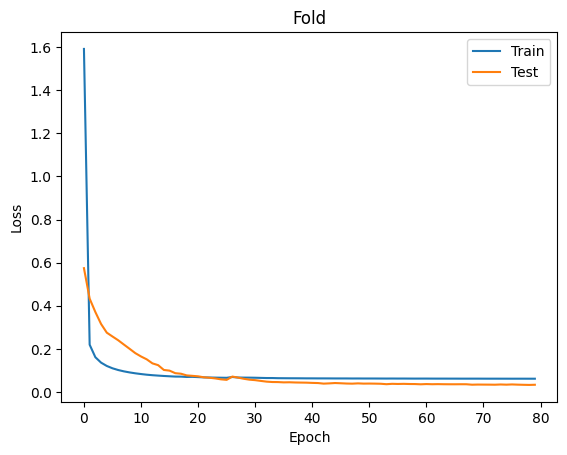

Tworzenie sampli treningowych...
Tworzenie sampli testowych...
Kształt X_train_samples: (50123, 200, 37)
Kształt Y_train_samples: (50123, 200, 12)
Using device: cuda
Finalny test loss po 80 : 0.14594663798791963


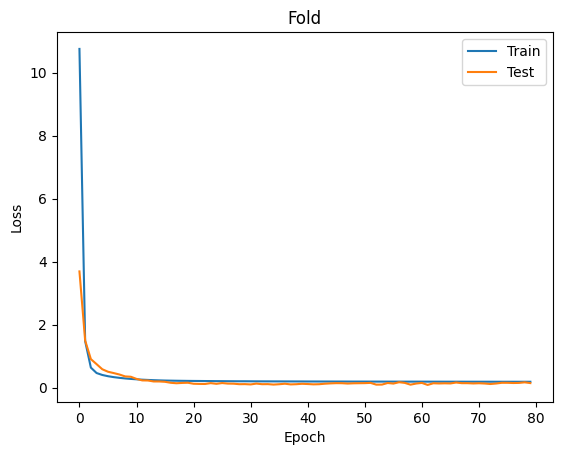

Tworzenie sampli treningowych...
Tworzenie sampli testowych...
Kształt X_train_samples: (48552, 200, 37)
Kształt Y_train_samples: (48552, 200, 12)
Using device: cuda
Finalny test loss po 80 : 0.8803537150032911


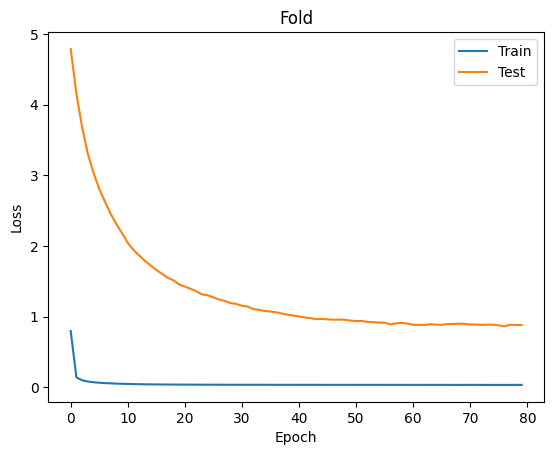

Tworzenie sampli treningowych...
Tworzenie sampli testowych...
Kształt X_train_samples: (53575, 200, 37)
Kształt Y_train_samples: (53575, 200, 12)
Using device: cuda
Finalny test loss po 80 : 0.0497759218077834


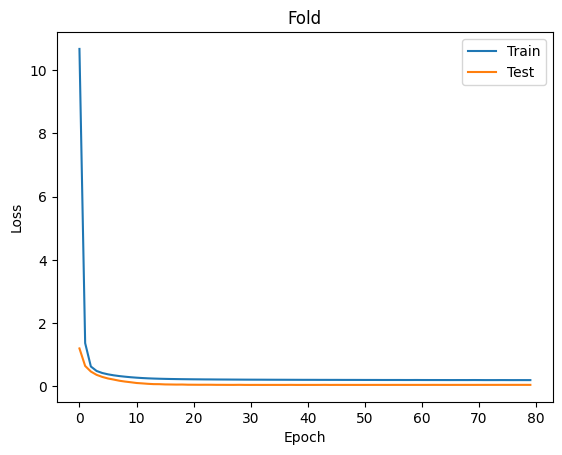

Tworzenie sampli treningowych...
Tworzenie sampli testowych...
Kształt X_train_samples: (49950, 200, 37)
Kształt Y_train_samples: (49950, 200, 12)
Using device: cuda
Finalny test loss po 80 : 0.05101731582015583


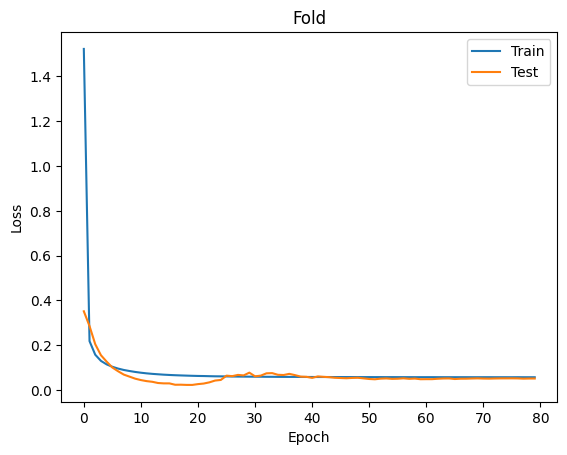

In [5]:

data = load_data_from_db()
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)

X, Y = create_x_y(data)
input_size = X[0].shape[1]
output_size = Y[0].shape[1]
print(input_size, output_size)



loo = LeaveOneOut()
all_fold_train = []
all_fold_test = []
all_fold_r2_test = []
i = 0

SEQUENCE_LENGTH = 200 # lub 30 jeśli wolisz, ale musi być spójne
STEP = 1 # step=1 daje najwięcej danych

lr = 1e-4

batch_size = 128
num_epochs = 80
weights = [
    # [1.0, 1.0, 1.0, 1.0, 1.0],
    # [0.8, 1.2, 1.5, 0.5, 1.0],
    [0.7, 1.4, 2.0, 0.3, 1.2],
    [0.6, 1.6, 2.5, 0.2, 1.3],
    [0.5, 1.8, 3.0, 0.1, 1.5],
    [1.0,1.0,2.5,0.1,0.4]
]
weight = [0.5, 1.8, 3.0, 0.1, 1.5]
# weight = weights[4]  # wybierz zestaw wag do testowania
# for weight in weights:

N_SPLITS = 5  # Ustal liczbę foldów (K). 5 lub 10 to dobry start.
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

print("Testing weight:", weight)
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    
    # if fold > 0:
    #     break
    i += 1


    X_train = [X[i] for i in train_idx]
    X_test  = [X[i] for i in test_idx]
    Y_train = [Y[i] for i in train_idx]
    Y_test  = [Y[i] for i in test_idx]

    Y_train_raw = [np.array(y, copy=True) for y in Y_train]  # zapisz oryginalne (nieprzeskalowane)


    # Y_train_raw = Y_train.copy()  # zachowaj surowe Y_train przed skalowaniem

    scaler_X, scaler_Y = create_scalers(X_train,Y_train)

    X_train, Y_train = scale_input(X_train,Y_train,scaler_X,scaler_Y)
    X_test, Y_test = scale_input(X_test,Y_test,scaler_X,scaler_Y)
    n_steps_ahead = 5  # number of future steps to predict


    print("Tworzenie sampli treningowych...")
    X_train_samples, Y_train_samples = create_sliding_windows(
        X_train, Y_train, SEQUENCE_LENGTH, STEP
    )
    print("Tworzenie sampli testowych...")
    X_test_samples, Y_test_samples = create_sliding_windows(
        X_test, Y_test, SEQUENCE_LENGTH, STEP
    )
    
    print(f"Kształt X_train_samples: {X_train_samples.shape}")
    print(f"Kształt Y_train_samples: {Y_train_samples.shape}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    model = LSTMStatePredictor(input_size=input_size, hidden_size=256, output_size=output_size, num_layers=1).to(device)



    
    
    X_train_tensor = torch.tensor(X_train_samples, dtype=torch.float32).to(device)
    Y_train_tensor = torch.tensor(Y_train_samples, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test_samples, dtype=torch.float32).to(device)
    Y_test_tensor = torch.tensor(Y_test_samples, dtype=torch.float32).to(device)

    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # optimizer = optim.Adam(model.parameters(), lr=lr)
    

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5)
    loss_cont = nn.MSELoss()
    loss_cat  = nn.CrossEntropyLoss()

    fold_train_losses = []
    fold_test_losses = []
    # num_epochs = 100
    all_r2_per_output = []
    fold_r2_scores = []

    
    
    for epoch in range(num_epochs):
        
        model.train()
        total_train_loss = 0

      
        

        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            
            # Model dostaje całą sekwencję 200 kroków
            # i zwraca predykcje dla całej sekwencji 200 kroków
            y_pred, _ = model(x_batch) 
            
            # y_pred ma kształt (batch_size, SEQUENCE_LENGTH, 12)
            
            # Obliczamy stratę dla całej sekwencji na raz
            # Musimy indeksować wymiar cech [:, :, ...]
            loss_progress = loss_cont(y_pred[:, :, 0:2], y_batch[:, :, 0:2])
            loss_fuel     = loss_cont(y_pred[:, :, 2:3], y_batch[:, :, 2:3])
            loss_wear     = loss_cont(y_pred[:, :, 3:7], y_batch[:, :, 3:7])
            loss_temp     = loss_cont(y_pred[:, :, 7:11], y_batch[:, :, 7:11])
            loss_wet      = loss_cont(y_pred[:, :, 11:], y_batch[:, :, 11:])
            
            # Sumujemy straty (tak jak miałeś)
            loss = (weight[0] * loss_progress + 
                    weight[1] * loss_fuel + 
                    weight[2] * loss_wear + 
                    weight[3] * loss_temp + 
                    weight[4] * loss_wet)
            
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            
        avg_train_loss = total_train_loss / len(train_loader)

        

        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                y_pred, _ = model(x_batch)
                
                loss_progress = loss_cont(y_pred[:, :, 0:2], y_batch[:, :, 0:2])
                loss_fuel     = loss_cont(y_pred[:, :, 2:3], y_batch[:, :, 2:3])
                loss_wear     = loss_cont(y_pred[:, :, 3:7], y_batch[:, :, 3:7])
                loss_temp     = loss_cont(y_pred[:, :, 7:11], y_batch[:, :, 7:11])
                loss_wet      = loss_cont(y_pred[:, :, 11:], y_batch[:, :, 11:])
            
                # ... (oblicz resztę strat) ...

                loss = (weight[0] * loss_progress + weight[1] * loss_fuel + weight[2] * loss_wear + weight[3] * loss_temp + weight[4] * loss_wet)
                total_test_loss += loss.item()
        
        avg_test_loss = total_test_loss / len(test_loader)
        
        # Scheduler używa straty walidacyjnej
        scheduler.step(avg_test_loss)
        fold_train_losses.append(avg_train_loss)
        fold_test_losses.append(avg_test_loss)

        
        # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
    print(f"Finalny test loss po {num_epochs} : {fold_test_losses[-1]}")
    plt.figure()
    plt.plot(fold_train_losses, label='Train')
    plt.plot(fold_test_losses, label='Test')
    plt.title(f'Fold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



    #     model.eval()
    #     with torch.no_grad():
    #         pred_test = model(X_test_tensor)
    #         test_loss = loss_cont(pred_test, Y_test_tensor).item()
    #         fold_test_losses.append(test_loss)
        
    #         scheduler.step(test_loss)
    #         print(f"Epoch {epoch+1}, current lr: {optimizer.param_groups[0]['lr']:.6f}")

            
    #         if epoch == num_epochs - 1:
    #             b, t, f = pred_test.shape
    #             pred_test_flat = pred_test.cpu().numpy().reshape(b*t, f)
    #             Y_test_flat = Y_test_tensor.cpu().numpy().reshape(b*t, f)

    #             # inverse transform
    #             pred_test_inv = scaler_Y.inverse_transform(pred_test_flat)
    #             Y_test_inv = scaler_Y.inverse_transform(Y_test_flat)

    #             # R² po cechach
    #             r2s = [r2_score(Y_test_inv[:, i], pred_test_inv[:, i]) for i in range(f)]
    #             avg_r2_per_output = np.mean(r2s)
    #             print("Avg R2 per output:", r2s)
    #             print("Mean R2:", avg_r2_per_output)

    #             # === DIAGNOSTYKA PER-FEATURE ===
    #             from sklearn.metrics import mean_squared_error
    #             print("\n--- DIAGNOSTYKA ---")

    #             # przygotuj dane surowe z treningu (przed skalowaniem!)
    #             # jeśli chcesz pełną dokładność, przechowuj Y_train_raw = Y_train (niezeskalowane) tuż po wczytaniu
    #             # tu tymczasowo przyjmujemy, że masz Y_train nieprzeskalowane dostępne jako oryginalne dane:
    #             flat_y_train = np.vstack([y for y in Y_train_raw])  # jeśli Y_train jest już scaled, zmień to na surowe Y_train_raw

    #             vars_train = flat_y_train.var(axis=0)
    #             means_train = flat_y_train.mean(axis=0)
    #             mins = flat_y_train.min(axis=0)
    #             maxs = flat_y_train.max(axis=0)

    #             print("Feature | var | mean | min | max")
    #             for i in range(f):
    #                 print(i, round(vars_train[i],6), round(means_train[i],6), round(mins[i],6), round(maxs[i],6))

    #             # baseline R² (predykcja średnią z train)
    #             mean_pred = np.tile(means_train.reshape(1,-1), (Y_test_inv.shape[0],1))
    #             baseline_r2 = [r2_score(Y_test_inv[:,i], mean_pred[:,i]) for i in range(f)]
    #             print("\nBaseline R2 per feature:", baseline_r2)

    #             # model R² + MSE + min/max pred
    #             for i in range(f):
    #                 r2 = r2_score(Y_test_inv[:,i], pred_test_inv[:,i])
    #                 mse = mean_squared_error(Y_test_inv[:,i], pred_test_inv[:,i])
    #                 print(f"feat {i}: R2={r2:.4f}, MSE={mse:.6f}, pred_min={pred_test_inv[:,i].min():.4f}, pred_max={pred_test_inv[:,i].max():.4f}")
    #             print("--- KONIEC DIAGNOSTYKI ---\n")

    #             num_features = Y_test_inv.shape[1]
    #             fig, axes = plt.subplots(nrows=(num_features + 2)//3, ncols=3, figsize=(15, 5*((num_features + 2)//3)))
    #             axes = axes.flatten()
    #             titles = ["Race progress","Lap progress","Fuel level","Tyre wear FL","Tyre wear FR","Tyre wear RL","Tyre wear RR",
    #                         "Tyre temp FL","Tyre temp FR","Tyre temp RL","Tyre temp RR","Track wetness"]
    #             for i in range(num_features):
    #                 ax = axes[i]
    #                 ax.scatter(Y_test_inv[:, i], pred_test_inv[:, i], s=10, alpha=0.6)
    #                 ax.plot([Y_test_inv[:, i].min(), Y_test_inv[:, i].max()],
    #                         [Y_test_inv[:, i].min(), Y_test_inv[:, i].max()],
    #                         'r--', linewidth=1.5, label='ideal line')
    #                 ax.set_title(f'{titles[i]} | R²={r2s[i]:.3f}')
    #                 ax.set_xlabel('True')
    #                 ax.set_ylabel('Predicted')
    #                 ax.legend()
    #                 ax.grid(True)

    #             for j in range(i+1, len(axes)):
    #                 fig.delaxes(axes[j])

    #             plt.tight_layout()
    #             plt.show()

    #             num_features = Y_test_inv.shape[1]
    #             titles = ["Race progress","Lap progress","Fuel level",
    #                     "Tyre wear FL","Tyre wear FR","Tyre wear RL","Tyre wear RR",
    #                     "Tyre temp FL","Tyre temp FR","Tyre temp RL","Tyre temp RR",
    #                     "Track wetness"]

    #             cols = 3
    #             rows = int(np.ceil(num_features / cols))
    #             fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 3))
    #             axes = axes.flatten()

    #             for i in range(num_features):
    #                 ax = axes[i]
    #                 ax.plot(Y_test_inv[:, i], label='True', color='blue', linewidth=1)
    #                 ax.plot(pred_test_inv[:, i], label='Pred', color='orange', linestyle='--', linewidth=1)
    #                 ax.set_title(f'{titles[i]} | R²={r2s[i]:.3f}')
    #                 ax.set_xlabel('Sample index')
    #                 ax.set_ylabel('Value')
    #                 ax.legend()
    #                 ax.grid(True)

    #             # usuń puste osie, jeśli niepełny ostatni rząd
    #             for j in range(i+1, len(axes)):
    #                 fig.delaxes(axes[j])

    #             plt.tight_layout()
    #             plt.show()
                                                
    # plt.figure()
    # plt.plot(fold_train_losses, label='Train')
    # plt.plot(fold_test_losses, label='Test')
    # plt.title(f'Fold')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.show()

del model, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor
torch.cuda.empty_cache()

In [ ]:
data = load_data_from_db()
# input_size = X[0].shape[1]
# output_size = Y[0].shape[1]
# random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)

X, Y = create_x_y(data)
input_size = X[0].shape[1]
output_size = Y[0].shape[1]
print(input_size, output_size)

# scaler_X, scaler_Y = create_scalers(X,Y)

# X_scaled, Y_scaled = scale_input(X,Y,scaler_X,scaler_Y)

# X_scaled = [scaler_X.transform(np.array(race)) for race in X]
# Y_scaled = [scaler_Y.transform(np.array(race)) for race in Y]



loo = LeaveOneOut()
all_fold_train = []
all_fold_test = []
all_fold_r2_test = []
i = 0

# lrs = [1e-3,1e-3,1e-3, 7e-4, 5e-4, 3e-4, 1e-4, 7e-5, 5e-5, 3e-5, 1e-5]
lr = 1e-3
# lr = 7e-5
# lr = 5e-4
# batch_sizes = [32, 64, 128, 256, 512]
batch_size = 128
# num_epochs = [50, 100, 150, 200, 300, 400]
num_epochs = 75
weights = [
    # [1.0, 1.0, 1.0, 1.0, 1.0],
    # [0.8, 1.2, 1.5, 0.5, 1.0],
    [0.7, 1.4, 2.0, 0.3, 1.2],
    [0.6, 1.6, 2.5, 0.2, 1.3],
    [0.5, 1.8, 3.0, 0.1, 1.5],
    [1.0,1.0,2.5,0.1,0.4]
]
weight = [0.5, 1.8, 3.0, 0.1, 1.5]
# weight = weights[4]  # wybierz zestaw wag do testowania
# for weight in weights:

print("Testing weight:", weight)
for fold, (train_idx, test_idx) in enumerate(loo.split(X)):
    
    if fold > 0:
        break
    i += 1


    X_train = [X[i] for i in train_idx]
    X_test  = [X[i] for i in test_idx]
    Y_train = [Y[i] for i in train_idx]
    Y_test  = [Y[i] for i in test_idx]

    Y_train_raw = [np.array(y, copy=True) for y in Y_train]  # zapisz oryginalne (nieprzeskalowane)


    # Y_train_raw = Y_train.copy()  # zachowaj surowe Y_train przed skalowaniem

    scaler_X, scaler_Y = create_scalers(X_train,Y_train)

    X_train, Y_train = scale_input(X_train,Y_train,scaler_X,scaler_Y)
    X_test, Y_test = scale_input(X_test,Y_test,scaler_X,scaler_Y)
    n_steps_ahead = 5  # number of future steps to predict


    all_X, all_Y = [], []
    for race_x, race_y in zip(X_train, Y_train):  
        X_r, Y_r = create_windows(race_x, race_y, window_size=30, n_steps_ahead=n_steps_ahead)
        all_X.append(X_r)
        all_Y.append(Y_r)

    X_train = np.vstack(all_X)  # shape: [N_samples, window_size, n_features]
    Y_train = np.vstack(all_Y) 
    all_X, all_Y = [], []
    for race_x, race_y in zip(X_test, Y_test):  
        X_r, Y_r = create_windows(race_x, race_y, window_size=30)
        all_X.append(X_r)
        all_Y.append(Y_r)
    X_test = np.vstack(all_X)  # shape: [N_samples, window_size, n_features]
    Y_test = np.vstack(all_Y)


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    model = LSTMStatePredictor(input_size=input_size, hidden_size=128, output_size=output_size,n_steps_ahead=n_steps_ahead, num_layers=1).to(device)



    
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).to(device)

    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    # optimizer = optim.Adam(model.parameters(), lr=lr)
    

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5)
    loss_cont = nn.MSELoss()
    loss_cat  = nn.CrossEntropyLoss()

    fold_train_losses = []
    fold_test_losses = []
    # num_epochs = 100
    all_r2_per_output = []
    fold_r2_scores = []

    
    
    for epoch in range(num_epochs):
        
        model.train()
        total_loss = 0

        # weights = torch.tensor(
        #     [0.8, 0.8, 2.0, 1.5, 1.5, 1.5, 1.5, 0.1, 0.1, 0.1, 0.1, 3.0],
        #     dtype=torch.float32,
        #     device=device
        # )

        # for x_batch, y_batch in train_loader:
        #     optimizer.zero_grad()
        #     pred = model(x_batch)
            
        #     # bierzemy ostatni krok z predykcji (lub całość, jeśli tak trenujesz)
        #     pred_flat = pred[:, -1, :]
        #     y_flat = y_batch[:, -1, :]
        #     # rozbijanie po grupach
        #     loss_progress = loss_cont(pred_flat[:, 0:2], y_flat[:, 0:2])
        #     loss_fuel     = loss_cont(pred_flat[:, 2:3], y_flat[:, 2:3])
        #     loss_wear     = loss_cont(pred_flat[:, 3:7], y_flat[:, 3:7])
        #     loss_temp     = loss_cont(pred_flat[:, 7:11], y_flat[:, 7:11])
        #     loss_wet      = loss_cont(pred_flat[:, 11:], y_flat[:, 11:])
        #     # łączymy straty z różnych grup z różnymi wagami
        #     loss =  weight[0] * loss_progress + \
        #             weight[1] * loss_fuel + \
        #             weight[2] * loss_wear + \
        #             weight[3] * loss_temp + \
        #             weight[4] * loss_wet
        #     # łączenie z wagami
        #     # loss = (0.8 * loss_progress +
        #     #         1.2 * loss_fuel +
        #     #         1.5 * loss_wear +
        #     #         0.5 * loss_temp +
        #     #         1.0 * loss_wet)

        #     # standardowy update
        #     loss.backward()
        #     optimizer.step()
        #     total_loss += loss.item()
        tf_prob = 0.7  # prawdopodobieństwo użycia prawdziwej wartości

        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()

            batch_size, seq_len, _ = x_batch.shape
            h_c = None
            x_input = x_batch.clone()  # startowe okno 30 kroków
            loss = 0.0

            for step in range(n_steps_ahead):  # generujemy 5 kroków
                y_pred, h_c = model(x_input, h_c)  # predykcja 1 kroku
                y_true_step = y_batch[:, step, :]

                # rozbijamy na grupy i liczymy stratę
                loss_progress = loss_cont(y_pred[:, 0:2], y_true_step[:, 0:2])
                loss_fuel     = loss_cont(y_pred[:, 2:3], y_true_step[:, 2:3])
                loss_wear     = loss_cont(y_pred[:, 3:7], y_true_step[:, 3:7])
                loss_temp     = loss_cont(y_pred[:, 7:11], y_true_step[:, 7:11])
                loss_wet      = loss_cont(y_pred[:, 11:], y_true_step[:, 11:])
                step_loss = weight[0]*loss_progress + weight[1]*loss_fuel + weight[2]*loss_wear + weight[3]*loss_temp + weight[4]*loss_wet
                loss += step_loss

                # Teacher forcing: decydujemy co wstawimy do okna na kolejny krok
                use_teacher = torch.rand(batch_size, device=x_batch.device) < tf_prob
                use_teacher = use_teacher.unsqueeze(1).float()  # shape [B,1]
                y_next_input = use_teacher * y_true_step + (1 - use_teacher) * y_pred

                # przesuwamy okno o 1 krok (autoreg)
                x_input = torch.cat([x_input[:, 1:, :], y_next_input.unsqueeze(1)], dim=1)

            loss.backward()
            optimizer.step()

        fold_train_losses.append(total_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            pred_test = model(X_test_tensor)
            test_loss = loss_cont(pred_test, Y_test_tensor).item()
            fold_test_losses.append(test_loss)
        
            scheduler.step(test_loss)
            print(f"Epoch {epoch+1}, current lr: {optimizer.param_groups[0]['lr']:.6f}")

            
            if epoch == num_epochs - 1:
                b, t, f = pred_test.shape
                pred_test_flat = pred_test.cpu().numpy().reshape(b*t, f)
                Y_test_flat = Y_test_tensor.cpu().numpy().reshape(b*t, f)

                # inverse transform
                pred_test_inv = scaler_Y.inverse_transform(pred_test_flat)
                Y_test_inv = scaler_Y.inverse_transform(Y_test_flat)

                # R² po cechach
                r2s = [r2_score(Y_test_inv[:, i], pred_test_inv[:, i]) for i in range(f)]
                avg_r2_per_output = np.mean(r2s)
                print("Avg R2 per output:", r2s)
                print("Mean R2:", avg_r2_per_output)

                # === DIAGNOSTYKA PER-FEATURE ===
                from sklearn.metrics import mean_squared_error
                print("\n--- DIAGNOSTYKA ---")

                # przygotuj dane surowe z treningu (przed skalowaniem!)
                # jeśli chcesz pełną dokładność, przechowuj Y_train_raw = Y_train (niezeskalowane) tuż po wczytaniu
                # tu tymczasowo przyjmujemy, że masz Y_train nieprzeskalowane dostępne jako oryginalne dane:
                flat_y_train = np.vstack([y for y in Y_train_raw])  # jeśli Y_train jest już scaled, zmień to na surowe Y_train_raw

                vars_train = flat_y_train.var(axis=0)
                means_train = flat_y_train.mean(axis=0)
                mins = flat_y_train.min(axis=0)
                maxs = flat_y_train.max(axis=0)

                print("Feature | var | mean | min | max")
                for i in range(f):
                    print(i, round(vars_train[i],6), round(means_train[i],6), round(mins[i],6), round(maxs[i],6))

                # baseline R² (predykcja średnią z train)
                mean_pred = np.tile(means_train.reshape(1,-1), (Y_test_inv.shape[0],1))
                baseline_r2 = [r2_score(Y_test_inv[:,i], mean_pred[:,i]) for i in range(f)]
                print("\nBaseline R2 per feature:", baseline_r2)

                # model R² + MSE + min/max pred
                for i in range(f):
                    r2 = r2_score(Y_test_inv[:,i], pred_test_inv[:,i])
                    mse = mean_squared_error(Y_test_inv[:,i], pred_test_inv[:,i])
                    print(f"feat {i}: R2={r2:.4f}, MSE={mse:.6f}, pred_min={pred_test_inv[:,i].min():.4f}, pred_max={pred_test_inv[:,i].max():.4f}")
                print("--- KONIEC DIAGNOSTYKI ---\n")

                num_features = Y_test_inv.shape[1]
                fig, axes = plt.subplots(nrows=(num_features + 2)//3, ncols=3, figsize=(15, 5*((num_features + 2)//3)))
                axes = axes.flatten()
                titles = ["Race progress","Lap progress","Fuel level","Tyre wear FL","Tyre wear FR","Tyre wear RL","Tyre wear RR",
                            "Tyre temp FL","Tyre temp FR","Tyre temp RL","Tyre temp RR","Track wetness"]
                for i in range(num_features):
                    ax = axes[i]
                    ax.scatter(Y_test_inv[:, i], pred_test_inv[:, i], s=10, alpha=0.6)
                    ax.plot([Y_test_inv[:, i].min(), Y_test_inv[:, i].max()],
                            [Y_test_inv[:, i].min(), Y_test_inv[:, i].max()],
                            'r--', linewidth=1.5, label='ideal line')
                    ax.set_title(f'{titles[i]} | R²={r2s[i]:.3f}')
                    ax.set_xlabel('True')
                    ax.set_ylabel('Predicted')
                    ax.legend()
                    ax.grid(True)

                for j in range(i+1, len(axes)):
                    fig.delaxes(axes[j])

                plt.tight_layout()
                plt.show()

                num_features = Y_test_inv.shape[1]
                titles = ["Race progress","Lap progress","Fuel level",
                        "Tyre wear FL","Tyre wear FR","Tyre wear RL","Tyre wear RR",
                        "Tyre temp FL","Tyre temp FR","Tyre temp RL","Tyre temp RR",
                        "Track wetness"]

                cols = 3
                rows = int(np.ceil(num_features / cols))
                fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 3))
                axes = axes.flatten()

                for i in range(num_features):
                    ax = axes[i]
                    ax.plot(Y_test_inv[:, i], label='True', color='blue', linewidth=1)
                    ax.plot(pred_test_inv[:, i], label='Pred', color='orange', linestyle='--', linewidth=1)
                    ax.set_title(f'{titles[i]} | R²={r2s[i]:.3f}')
                    ax.set_xlabel('Sample index')
                    ax.set_ylabel('Value')
                    ax.legend()
                    ax.grid(True)

                # usuń puste osie, jeśli niepełny ostatni rząd
                for j in range(i+1, len(axes)):
                    fig.delaxes(axes[j])

                plt.tight_layout()
                plt.show()
                                                
    plt.figure()
    plt.plot(fold_train_losses, label='Train')
    plt.plot(fold_test_losses, label='Test')
    plt.title(f'Fold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

del model, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor
torch.cuda.empty_cache()

    # if i == 1:
    #     break

                # opcjonalnie: wróć do kształtu 3D, jeśli chcesz generować sekwencje
                # pred_test_inv = pred_test_inv.reshape(b, t, f)
                # Y_test_inv    = Y_test_inv.reshape(b, t, f)


        
    # all_fold_train.append(fold_train_losses)
    # all_fold_test.append(fold_test_losses)
    # # all_fold_r2.append(fold_r2_scores)

    # # Compute R^2 score for the test set
    # r2 = r2_score(Y_test_tensor.cpu().numpy(), pred_test.cpu().numpy())
    # all_fold_r2_test.append(r2)


In [ ]:
def create_window_pred(sequence_x, window_size, n_steps_ahead=5):
    X, Y = [], []
    curr_len = len(sequence_x)

    # for t in range(1, len(sequence_x)):
    start = max(0, curr_len - window_size)
    window = sequence_x[start:curr_len]

    # padding na początku, jeśli okno krótsze niż window_size
    pad_len = window_size - len(window)
    if pad_len > 0:
        window = np.vstack([np.zeros((pad_len, sequence_x.shape[1])), window])
    X.append(window)

        

    return np.array(X)

Generate state predictions

In [ ]:
del X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor
window_size = 30
X_init = X_test[0]  
print(X_init)  # skalowane
# current_window = torch.tensor(X_init, dtype=torch.float32).unsqueeze(0).to(device)
race_states = []
race_states.append(X_init)
current_window = create_window_pred(race_states,window_size=window_size)
current_window = torch.tensor(current_window, dtype=torch.float32).to(device)
model.eval()
for _ in range(1000):
    with torch.no_grad():
        pred_test = model(current_window)
        print(pred_test)
        
        race_states.append(pred_test.cpu().numpy())
        current_window = create_window_pred(race_states, window_size=window_size)
        current_window = torch.tensor(current_window, dtype=torch.float32).to(device)

        pred_test_inv = scaler_Y.inverse_transform(pred_test.cpu().numpy())
        Y_test_inv = scaler_Y.inverse_transform(current_window.squeeze(0).cpu().numpy())



In [ ]:
# num_features = y_cont_orig.shape[1]
# plt.figure(figsize=(15, 3 * num_features))
# titles = ['Lap progress','Race progress', 'Fuel level', 'Wheel1 wear', 'Wheel2 wear', 'Wheel3 wear', 'Wheel4 wear', 'Wheel1 temp','Wheel2 temp','Wheel3 temp','Wheel4 temp','AvgPathWetness']
# for i in range(num_features):
#     plt.subplot(num_features, 1, i + 1)
#     plt.plot(y_cont_orig[:, i], label='Rzeczywiste')
#     plt.plot(cont_pred_orig[:, i], label='Predykcja', linestyle='--')
#     plt.title(f'{titles[i]}')
#     plt.legend()



# plt.tight_layout()
# plt.show()

In [ ]:
del model, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor
torch.cuda.empty_cache()

Visualize var to generate by alghoritm(weather,damages,itd)

In [4]:
# Nazwy cech według Twojego opisu
feature_names = [
    "mLastImpactET",
    "mLastImpactMagnitude",
    "mNumPenalties",
    "mRaining",
    "mAmbientTemp",
    "mTrackTemp",
    "mDentSeverity[0]",
    "mDentSeverity[1]",
    "mDentSeverity[2]",
    "mDentSeverity[3]",
    "mDentSeverity[4]",
    "mDentSeverity[5]",
    "mDentSeverity[6]",
    "mDentSeverity[7]",
    "has_last_lap",
    "mFinishStatus",
    "mTotalLaps",
    "mSector",
    "mNumPitstops",
    "mInPits",
    "mFrontTireCompoundIndex",
    "multiplier"
]

# Jeśli masz mniej niż 24 nazw, dodaj puste lub dopisz brakujące
while len(feature_names) < 24:
    feature_names.append(f"Feature {len(feature_names)}")

data = load_data_from_db()
race = np.array(data[1])  # pierwszy wyścig
last_24_features = race[:, -24:]  # shape: [liczba_kroków, 24]

# for i in range(24):
#     plt.figure(figsize=(10, 3))
#     plt.plot(last_24_features[:, i])
#     plt.title(f"{feature_names[i]}")
#     plt.xlabel("Krok")
#     plt.ylabel("Wartość")
#     plt.tight_layout()
#     plt.show()

# data = load_data_from_db()
# num_features = 24

# # Inicjalizacja list na min i max dla każdej cechy
# feature_mins = [float('inf')] * num_features
# feature_maxs = [float('-inf')] * num_features

# for race in data:
#     race = np.array(race)
#     last_24_features = race[:, -num_features:]  # shape: [liczba_kroków, 24]
#     for i in range(num_features):
#         feature_min = np.min(last_24_features[:, i])
#         feature_max = np.max(last_24_features[:, i])
#         if feature_min < feature_mins[i]:
#             feature_mins[i] = feature_min
#         if feature_max > feature_maxs[i]:
#             feature_maxs[i] = feature_max

# for i in range(num_features):
#     print(f"{feature_names[i]}: min={feature_mins[i]}, max={feature_maxs[i]}")






In [19]:
for race in data:
    print("Długość wyścigu:", race[50][19])
    # print("liczba próbek:", len(race))
    # print("Delta czasu między próbkami (średnia):", np.mean(np.diff([step[2] for step in race])))
    print("zmiana kroku", 1/len(race))
    print(len(race))

Długość wyścigu: 734.0
zmiana kroku 0.0006049606775559589
1653
Długość wyścigu: 733.0
zmiana kroku 0.0003812428516965307
2623
Długość wyścigu: 735.0
zmiana kroku 0.0004050222762251924
2469
Długość wyścigu: 1026.0
zmiana kroku 0.00035423308537017357
2823
Długość wyścigu: 1032.0
zmiana kroku 0.0003714710252600297
2692
Długość wyścigu: 1935.0
zmiana kroku 0.00019817677368212446
5046
Długość wyścigu: 1932.0
zmiana kroku 0.00019972039145196724
5007
Długość wyścigu: 733.0
zmiana kroku 0.0005580357142857143
1792
Długość wyścigu: 1033.0
zmiana kroku 0.0003635041802980734
2751
Długość wyścigu: 1334.0
zmiana kroku 0.0002848191398461977
3511
Długość wyścigu: 1933.0
zmiana kroku 0.0002068680182043856
4834
Długość wyścigu: 734.0
zmiana kroku 0.0005790387955993051
1727
Długość wyścigu: 735.0
zmiana kroku 0.0006060606060606061
1650
Długość wyścigu: 1934.0
zmiana kroku 0.0002195389681668496
4555
Długość wyścigu: 1933.0
zmiana kroku 0.00020846362309776944
4797
Długość wyścigu: 1933.0
zmiana kroku 0.000

In [ ]:
race = np.array(data[0])  # pierwszy wyścig

lap_distance = race[:, 0]  # podaj właściwy indeks dystansu okrążenia
sector = race[:, 29]
print("Unikalne sektory:", np.unique(sector))

for i in range(1, len(race)):
    if sector[i] != sector[i-1]:
        print(f"Sektor zmienił się na {sector[i]} przy dystansie {lap_distance[i]}")

Prawdopodobieństwo wystąpienia uderzenia: 0.4980827089847207
22007.326171875


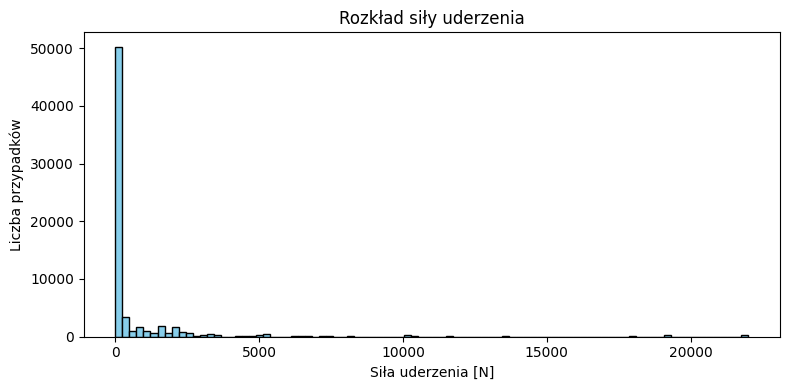

Bin edges: [    0.           244.52584635   489.05169271   733.57753906
   978.10338542  1222.62923177  1467.15507813  1711.68092448
  1956.20677083  2200.73261719  2445.25846354  2689.7843099
  2934.31015625  3178.8360026   3423.36184896  3667.88769531
  3912.41354167  4156.93938802  4401.46523438  4645.99108073
  4890.51692708  5135.04277344  5379.56861979  5624.09446615
  5868.6203125   6113.14615885  6357.67200521  6602.19785156
  6846.72369792  7091.24954427  7335.77539062  7580.30123698
  7824.82708333  8069.35292969  8313.87877604  8558.4046224
  8802.93046875  9047.4563151   9291.98216146  9536.50800781
  9781.03385417 10025.55970052 10270.08554687 10514.61139323
 10759.13723958 11003.66308594 11248.18893229 11492.71477865
 11737.240625   11981.76647135 12226.29231771 12470.81816406
 12715.34401042 12959.86985677 13204.39570313 13448.92154948
 13693.44739583 13937.97324219 14182.49908854 14427.0249349
 14671.55078125 14916.0766276  15160.60247396 15405.12832031
 15649.65416667 

In [8]:
impact_magnitudes = []
not_zero_impacts = 0
for race in data:
    race = np.array(race)
    # Zakładam, że mLastImpactMagnitude to jedna z ostatnich 24 cech, np. indeks 1
    impact_magnitudes.extend(race[:, -26])  # -23 jeśli to druga cecha z końca, popraw jeśli inny indeks


for magnitude in impact_magnitudes:
    if magnitude > 0:
        not_zero_impacts += 1


prob_imp = not_zero_impacts / len(impact_magnitudes)
print("Prawdopodobieństwo wystąpienia uderzenia:", prob_imp)

impact_magnitudes = np.array(impact_magnitudes)

print(max(impact_magnitudes))
plt.figure(figsize=(8, 4))
plt.hist(impact_magnitudes, bins=90, color='skyblue', edgecolor='black')
plt.title("Rozkład siły uderzenia")
plt.xlabel("Siła uderzenia [N]")
plt.ylabel("Liczba przypadków")
plt.tight_layout()
plt.show()


# Zbierz wszystkie wartości siły uderzenia
impact_magnitudes = []
for race in data:
    race = np.array(race)
    impact_magnitudes.extend(race[:, -26])  # -26 jeśli to druga cecha z końca

impact_magnitudes = np.array(impact_magnitudes)

# Policz histogram (np. 20 przedziałów)
hist, bin_edges = np.histogram(impact_magnitudes, bins=90, density=True)
print("Bin edges:", bin_edges)
probabilities = hist / hist.sum()  # prawdopodobieństwa dla każdego przedziału
print(probabilities)

np.save('E:/pracadyp/Race-optimization-reinforcement-learning/data/probabilities_impact/probabilities.npy', probabilities)
np.save('E:/pracadyp/Race-optimization-reinforcement-learning/data/probabilities_impact/bin_edges.npy', bin_edges)


In [ ]:
data = load_data_from_db()
num_features = 36

# Inicjalizacja list na min i max dla każdej cechy
feature_mins = [float('inf')] * num_features
feature_maxs = [float('-inf')] * num_features

for race in data:
    race = np.array(race)
    all_features = race[:, -num_features:]  # shape: [liczba_kroków, 36]
    for i in range(num_features):
        feature_min = np.min(all_features[:, i])
        feature_max = np.max(all_features[:, i])
        if feature_min < feature_mins[i]:
            feature_mins[i] = feature_min
        if feature_max > feature_maxs[i]:
            feature_maxs[i] = feature_max

for i in range(num_features):
    print(f": min={feature_mins[i]}, max={feature_maxs[i]}")